In [1]:
import glob
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import xml.etree.ElementTree as ET
import json


def jsonify(root):
    parsed = dict()
    for child in root:
        children = child.getchildren()
        if len(children) == 0:
            parsed[f"{child.tag}"] = [child.text]
        else:
            if f"{child.tag}" in parsed.keys():
                parsed[f"{child.tag}"].append(jsonify(children))
            else:
                parsed[f"{child.tag}"] = [jsonify(children)]
    for item in parsed.keys():
        if len(parsed[item]) == 1:
            parsed[item] = parsed[item][0]
    return parsed


def xml_json(filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    return jsonify(root)


class box():
    def __init__(self, box_dict):
        self.xmin = int(box_dict["xmin"])
        self.xmax = int(box_dict["xmax"])
        self.ymin = int(box_dict["ymin"])
        self.ymax = int(box_dict["ymax"])
        self.x = False
        pass

    @property
    def width(self):
        return self.xmax - self.xmin

    @property
    def height(self):
        return self.ymax - self.ymin

    @property
    def center(self):
        return (int((self.xmax + self.xmin)/2), int((self.ymax + self.ymin)/2))

    @property
    def area(self):
        return self.width * self.height

    # @property
    # def x(self):
    #     return self.__x

    def set_x(self, close):
        if not self.x:
            self.x = close
        return

    def __sub__(self, new):
        i = np.array(list(self.center))
        j = np.array(list(new.center))
        return np.sqrt(np.sum(np.square(i-j)))

    def patch(self, ax=None):
        if self.x:
            color = 'red'
        else:
            color = "green"

        rect = patches.Rectangle((self.xmin, self.ymin), self.xmax - self.xmin,
                                 self.ymax - self.ymin, linewidth=1, edgecolor=color, facecolor='none')
        center = patches.Circle(self.center, radius=5,
                                edgecolor=color, facecolor=color)
        if ax != None:
            ax.add_patch(rect)
            ax.add_patch(center)
        return rect, center

    def __str__(self):
        return f"(w,h), {self.width}, {self.height}\ncenter:{self.center}\narea:{self.area}"

    def __repr__(self):
        return str(self)


def get_filenames(folder="to isha"):
    file_names = []
    for dirname, directs, files in os.walk(folder):
        for file in files:
            name = f"{dirname}/{file}"
            file_names.append(name)
    return (file_names)


def get_raw_files(files):
    jsons = []
    images = dict()
    for name in files:
        if ".xml" in name:
            jsons.append(xml_json(name))
        elif ".png" or ".jpg" or ".jpeg" in name:
            images[name.split("/")[-1]] = np.array(cv2.imread(name))
    return jsons, images


def too_close(a, b, threshold=1):
    prespective_similarity = min(a.area/b.area, b.area/a.area)  # size of box
    inverse_relative_distance = np.sqrt((max(a.area, b.area)))/(a - b)
    state = prespective_similarity * inverse_relative_distance
    return state > threshold


def too_close(a, b, threshold=1):
    prespective_similarity = min(a.area/b.area, b.area/a.area)  # size of box
    inverse_relative_distance = (max(a.area, b.area))/((a - b)**2)
    state = prespective_similarity * inverse_relative_distance
    return state > threshold


def validate_image(image, json_file, show_image=False, path=True, thresh=0.75):
    if path:
        image = plt.imread(image)
        im_det = json.loads(open(json_file, "r").read())
    else:
        im_det = json_file

    boxs = []
    done = set()

    if "object" in im_det.keys():
        if type(im_det["object"]) == list:
            for bo in im_det["object"]:
                b = box(bo["bndbox"])
                boxs.append(b)
        else:
            bo = im_det["object"]
            b = box(bo["bndbox"])
            boxs.append(b)

    for b in boxs:
        for c in boxs:
            current = [str(b), str(c)]
            current.sort()
            key = str(hash(str(current)))
            if b != c and key not in done:
                done.update({key})
                close = too_close(b, c, threshold=thresh)
                b.set_x(close)
                c.set_x(close)

    violations = 0
    for b in boxs:
        violations += int(b.x)

    if show_image:
        fig, ax = plt.subplots(1)
        fig.set_size_inches(10.5, 5.5)
        for b in boxs:
            b.patch(ax)
        ax.imshow(image)
        plt.show()
    return violations


def convert_detections_new_format(filepath, threshold):
    for each in glob.glob(filepath + "/*.json"):
        print(each)
        infile = each
        outfile = each.split('.json')[0] + '_converted.json'

        with open(infile, "r") as read_file:
            data = json.load(read_file)

        formatted_detections = dict()
        formatted_detections['object'] = []

        print(len(data.keys()))
        for key in data.keys():
            # print(key)
            if float(key) >= threshold:
                each = data[key]
                box = dict()

                box['bndbox'] = dict()
                box['bndbox']['xmin'] = each[0]
                box['bndbox']['ymin'] = each[1]
                box['bndbox']['xmax'] = each[2]
                box['bndbox']['ymax'] = each[3]
            formatted_detections['object'].append(box)

        print(formatted_detections)
        formatted_detections
        with open(filepath + '/' + outfile, "w+") as out_file:
            out_file.write(json.dumps(formatted_detections))


/home/subhankar/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in double_scalars


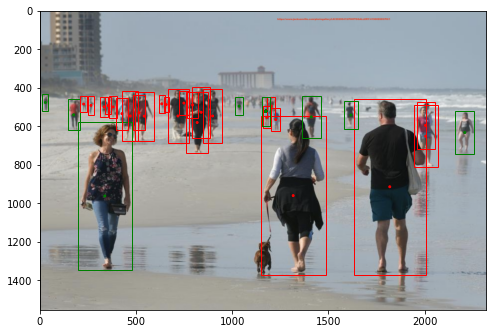

violations: 26


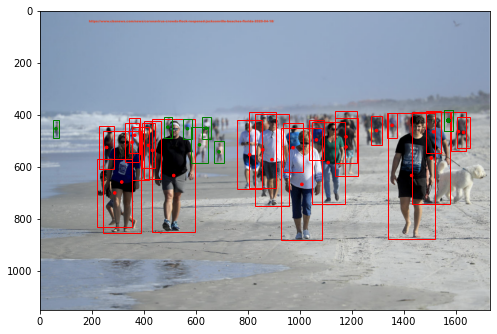

violations: 27


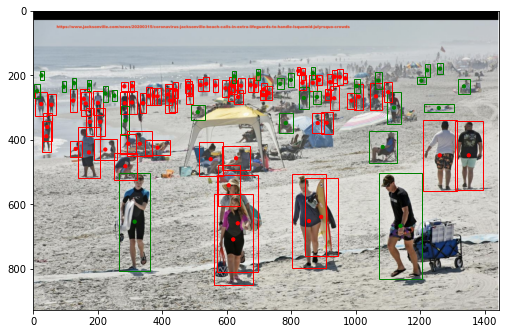

violations: 72


In [2]:

# path to json and path to image code
# ----------------------------------
path = 'jax/'

# comment out if detections already converted
#convert_detections_new_format(path, threshold=0.3)

for each in os.listdir(path):
    if ".png" in each or ".jpg" in each or ".jpeg" in each:
        image_path = path + each
        json_path = path + each.split('.')[0] + '_converted.json'
        
        violations = validate_image(image_path, json_path, show_image = True, path = True, thresh = 0.75)
        print(f"violations: {violations}")

# xml code
# --------
# files = get_filenames(folder = "to isha")
# jsons, images = get_raw_files(files)
# for im_num in range(len(jsons)):
#     image_path = images[jsons[im_num]["filename"]]
#     json_path = jsons[im_num]
#     violations = validate_image(image_path, json_path, show_image = True, path = False)
#     print(violations)